![](../images/logos.jpg "MiCMOR, KIT Campus Alpin")

**[MiCMOR](https://micmor.kit.edu) [SummerSchool "Environmental Data Science: From Data Exploration to Deep Learning"](https://micmor.kit.edu/sites/default/files/MICMoR%20Summer%20School%202019%20Flyer.pdf)**  
IMK-IFU KIT Campus Alpin, Sept. 4 - 13 2019, Garmisch-Partenkirchen, Germany.

---

# Data integration for Yawei

**Plan:**   
- we need to integrate the data, therefore we need to make sure the coorindates match
- we make one of the files the 'master' - all the others will be converted to match this ones' coordinates
- we also rename the coordinates the `lat`, `lon`, and `time` for all files
- at the end plot we also match units and make the plotting scale comparible
- the ERA data is averaged in the last plot

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import xarray as xr
import matplotlib.pylab as plt

## Dataset 1: ESACCI

This dataset will be used as a reference as the coordinates are center cell and it spans' the entire globe.
However, we still ne to fix it a bit since there is actually 1 step in the time dimension.
If we want to get rid of this dimension since it only has one step we can use `squeeze`...


In [3]:
# load dataset and show original properties
esacci = xr.open_dataset('Yawei_ncfiles/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20170401000000-fv04.4.nc')
esacci

<xarray.Dataset>
Dimensions:         (lat: 720, lon: 1440, time: 1)
Coordinates:
  * lat             (lat) float32 89.875 89.625 89.375 ... -89.625 -89.875
  * lon             (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * time            (time) datetime64[ns] 2017-04-01
Data variables:
    t0              (time, lat, lon) datetime64[ns] ...
    sm              (time, lat, lon) float32 ...
    sm_uncertainty  (time, lat, lon) float32 ...
    dnflag          (time, lat, lon) float32 ...
    flag            (time, lat, lon) float32 ...
    freqbandID      (time, lat, lon) float32 ...
    mode            (time, lat, lon) float32 ...
    sensor          (time, lat, lon) float32 ...
Attributes:
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    institution:                Technische Universität Wien (AUT); Transmissi...
    contact:                    cci_sm_contact@eodc.eu
    source:                     WARP 5.5R1.1/AMI-WS/ERS12 Level 2 

<xarray.Dataset>
Dimensions:         (lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    t0              (lat, lon) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    sm              (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sm_uncertainty  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dnflag          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    flag            (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    freqbandID      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    mode            (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sensor          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    institution:                Te

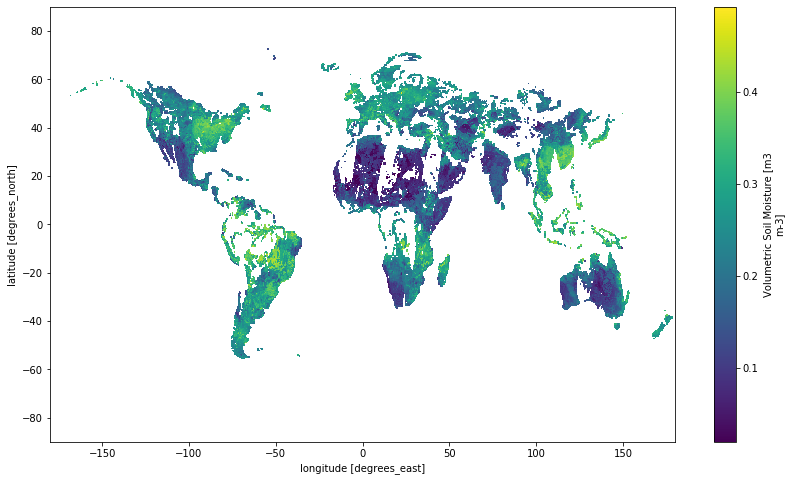

In [4]:
# remove the time dimension as we only have one layer anyways...
# also sort the latitudes so they are oriented from -90 to 90 like in the other datasets

esacci_clean = esacci.squeeze(drop=True).sortby('lat')
display(esacci_clean)
esacci_clean.sm.plot(figsize=(14,8));

## Dataset 2: ERA


In [5]:
era = xr.open_dataset('Yawei_ncfiles/ERA_April2017_0pm.nc')
era

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 30)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2017-04-01 2017-04-02 ... 2017-04-30
Data variables:
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-08-23 09:24:24 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

<xarray.Dataset>
Dimensions:  (lat: 600, lon: 1440, time: 30)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-01 2017-04-02 ... 2017-04-30
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
Data variables:
    swvl1    (time, lat, lon) float64 1.878e-06 1.878e-06 ... 1.878e-06 nan
Attributes:
    Conventions:  CF-1.6
    history:      2019-08-23 09:24:24 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

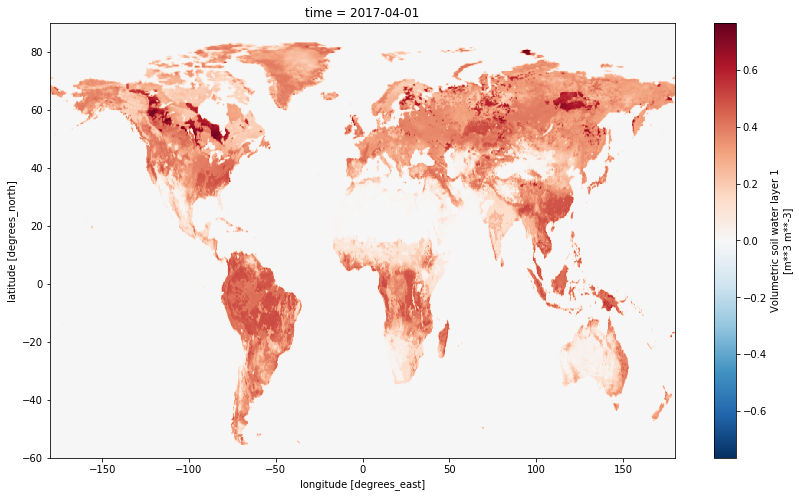

In [6]:
# first we rename the dimensions: latitude->lat and longitude->lon and also coordinates
era2 = era.rename_dims({'latitude': 'lat', 'longitude': 'lon'})
era2 = era2.rename_vars({'latitude': 'lat', 'longitude': 'lon'})

# then we go from 0...360 lons to -180 to 180
era2.coords['lon'] = (era2.coords['lon'] + 180) % 360 - 180
era3 = era2.sortby(era2.lon)

# and now we interpolate to the resolution/ extent of the esacci2 dataset
# finally we slice to -60 ... 90 latitude since one dataset has this extent 
era_clean = era3.interp(lon=esacci_clean.lon, lat=esacci_clean.lat).sel(lat=slice(-60,90))

display(era_clean)

# we select the first day (index on time axis = 0)
era_clean.swvl1.isel(time=0).plot(figsize=(14,8));

## Dataset 3: GLDAS

In [7]:
gldas = xr.open_dataset('Yawei_ncfiles/GLDAS_NOAH025_M.A201704.021.nc4')
gldas

<xarray.Dataset>
Dimensions:                (bnds: 2, lat: 600, lon: 1440, time: 1)
Coordinates:
  * lat                    (lat) float32 -59.875 -59.625 ... 89.625 89.875
  * lon                    (lon) float32 -179.875 -179.625 ... 179.625 179.875
  * time                   (time) datetime64[ns] 2017-04-01
Dimensions without coordinates: bnds
Data variables:
    time_bnds              (time, bnds) datetime64[ns] ...
    Swnet_tavg             (time, lat, lon) float32 ...
    Lwnet_tavg             (time, lat, lon) float32 ...
    Qle_tavg               (time, lat, lon) float32 ...
    Qh_tavg                (time, lat, lon) float32 ...
    Qg_tavg                (time, lat, lon) float32 ...
    Snowf_tavg             (time, lat, lon) float32 ...
    Rainf_tavg             (time, lat, lon) float32 ...
    Evap_tavg              (time, lat, lon) float32 ...
    Qs_acc                 (time, lat, lon) float32 ...
    Qsb_acc                (time, lat, lon) float32 ...
    Qsm_acc      

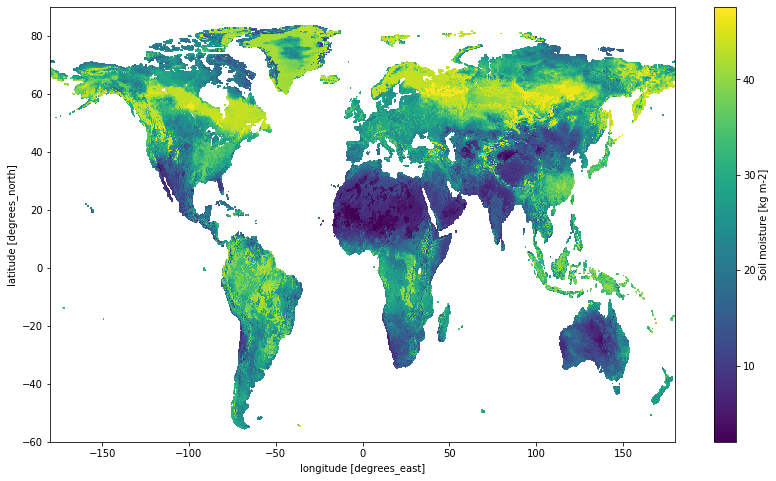

In [8]:
gldas_clean = gldas.squeeze(drop=True)
gldas_clean.SoilMoi0_10cm_inst.plot(figsize=(14,8));

## Dataset 4: NPR

In [9]:
npr = xr.open_dataset('Yawei_ncfiles/NPR_SMOPS_CMAP_D20170401.nc')
npr

<xarray.Dataset>
Dimensions:          (Latitude: 720, Longitude: 1440)
Dimensions without coordinates: Latitude, Longitude
Data variables:
    Blended_SM       (Latitude, Longitude) float32 ...
    NRT_SMOS_SM      (Latitude, Longitude) float32 ...
    SMOS_SM          (Latitude, Longitude) float32 ...
    ASCAT_A_SM       (Latitude, Longitude) float32 ...
    ASCAT_B_SM       (Latitude, Longitude) float32 ...
    AMSR2_SM         (Latitude, Longitude) float32 ...
    Spare_SM1        (Latitude, Longitude) int16 ...
    Blended_hour     (Latitude, Longitude) int8 ...
    Blended_minute   (Latitude, Longitude) int8 ...
    NRT_SMOS_hour    (Latitude, Longitude) int8 ...
    NRT_SMOS_minute  (Latitude, Longitude) int8 ...
    SMOS_hour        (Latitude, Longitude) int8 ...
    SMOS_minute      (Latitude, Longitude) int8 ...
    ASCAT_A_hour     (Latitude, Longitude) int8 ...
    ASCAT_A_minute   (Latitude, Longitude) int8 ...
    ASCAT_B_hour     (Latitude, Longitude) int8 ...
    ASCAT_

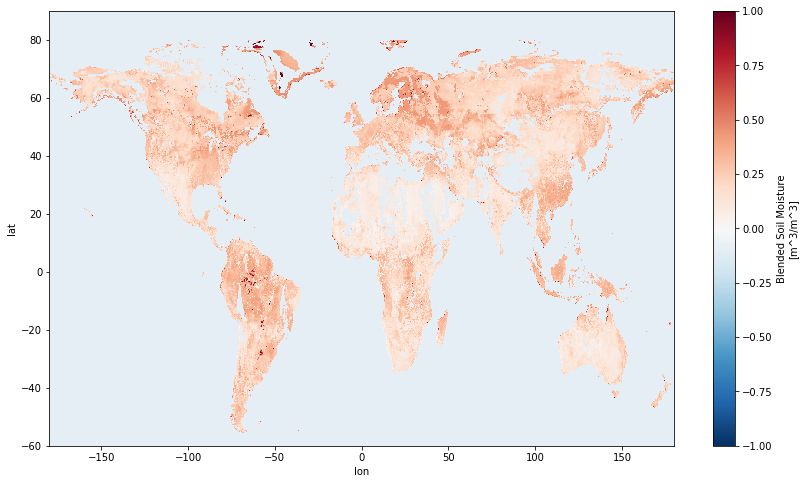

In [10]:
# first we rename the dimensions: latitude->lat and longitude->lon and also coordinates
npr2 = npr.rename_dims({'Latitude': 'lat', 'Longitude': 'lon'})
#npr2 = npr2.rename_vars({'Latitude': 'lat', 'Longitude': 'lon'})

# this file does not have coordinates. We add them and set from the esacci file
# since the data on latitude is oriented from 90 to -90 we have to invert the lat again with [::-1]
# then, we sort it again so everything is nice and compatible
npr2['lon'] = esacci_clean.lon.values
npr2['lat'] = esacci_clean.lat.values[::-1]
npr3 = npr2.set_coords(['lon','lat']).sortby('lat')

# and again select from -60 to 90
npr_clean = npr3.sel(lat=slice(-60,90))
npr_clean.Blended_SM.plot(figsize=(14,8));

This dataset does not have any coordinates. So we set the...

## Export the files to disk

Note that thew files have the original units and dimensions (era!)

In [11]:
esacci_clean.to_netcdf('esacci_cleam.nc')
era_clean.to_netcdf('esacci_cleam.nc')
gldas_clean.to_netcdf('esacci_cleam.nc')
npr_clean.to_netcdf('esacci_cleam.nc')

/Users/werner-ch/.pyenv/versions/3.7.3/envs/ds-default/lib/python3.7/site-packages/ipykernel_launcher.py:4: SerializationWarning: saving variable Blended_SM with floating point data as an integer dtype without any _FillValue to use for NaNs
  after removing the cwd from sys.path.
/Users/werner-ch/.pyenv/versions/3.7.3/envs/ds-default/lib/python3.7/site-packages/ipykernel_launcher.py:4: SerializationWarning: saving variable NRT_SMOS_SM with floating point data as an integer dtype without any _FillValue to use for NaNs
  after removing the cwd from sys.path.
/Users/werner-ch/.pyenv/versions/3.7.3/envs/ds-default/lib/python3.7/site-packages/ipykernel_launcher.py:4: SerializationWarning: saving variable SMOS_SM with floating point data as an integer dtype without any _FillValue to use for NaNs
  after removing the cwd from sys.path.
/Users/werner-ch/.pyenv/versions/3.7.3/envs/ds-default/lib/python3.7/site-packages/ipykernel_launcher.py:4: SerializationWarning: saving variable ASCAT_A_SM wi

## Summary plot

We also need to select the right variables and match units...
Then we use the same scale for all plots so they are comparable (vmin, vmax)...


/Users/werner-ch/.pyenv/versions/3.7.3/envs/ds-default/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


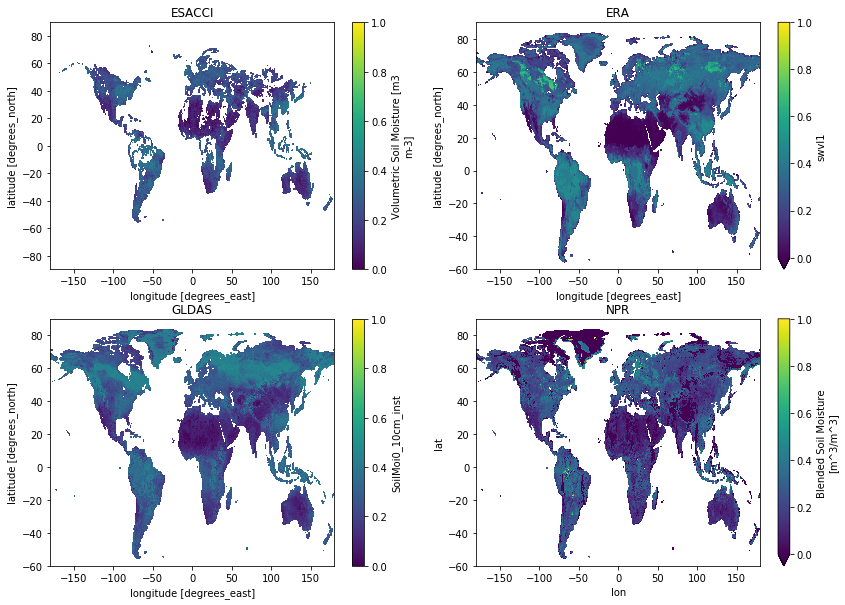

In [13]:
fig, ax = plt.subplots(2,2, figsize=(14,10))

# add the plots to the axes, use the nodata mask of GLDAS to mask the other plots, too

# unit m3 m-3
esacci_clean.sm.plot(ax=ax[0,0], vmin=0, vmax=1)

# unit m3 m-3
# is you want a single day uncomment the next line
#era_clean.swvl1.isel(time=0).where(gldas_clean.ESoil_tavg > -9999).plot(ax=ax[0,1], vmin=0, vmax=1)

# if you want the mean over the time axis
era_clean.swvl1.mean(dim='time').where(gldas_clean.ESoil_tavg > -9999).plot(ax=ax[0,1], vmin=0, vmax=1)

# unit kg m-2 -> / 100
(gldas_clean.SoilMoi0_10cm_inst / 100).plot(ax=ax[1,0], vmin=0, vmax=1)

# unit m3 m-3
npr_clean.Blended_SM.where(gldas_clean.ESoil_tavg > -9999).plot(ax=ax[1,1], vmin=0, vmax=1)

# add titles
ax[0,0].set_title('ESACCI')
ax[0,1].set_title('ERA')
ax[1,0].set_title('GLDAS')
ax[1,1].set_title('NPR');